In [5]:
import gym
import numpy as np

# Define the custom Gym environment for the mass-spring-damper system
class MassSpringDamperEnv(gym.Env):
    def __init__(self):
        super(MassSpringDamperEnv, self).__init__()

        # System parameters
        self.m = 1.0  # Mass (kg)
        self.k = 1.0  # Spring constant (N/m)
        self.c = 0.1  # Damping coefficient (N*s/m)

        # Simulation parameters
        self.dt = 0.01  # Time step (s)
        self.max_steps = 1000  # Maximum simulation steps
        self.current_step = 0

        # State and action spaces
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(2,))

        # Initial state
        self.state = None

    def reset(self):
        # Reset the environment to an initial state
        self.state = np.array([10.0, 0.0])  # Initial position and velocity
        self.current_step = 0
        return self.state

    def step(self, action):
        # Apply control action and simulate one time step using Euler integration
        force = action[0]
        position, velocity = self.state

        acceleration = (force - self.c * velocity - self.k * position) / self.m
        velocity += acceleration * self.dt
        position += velocity * self.dt

        self.state = np.array([position, velocity])
        self.current_step += 1

        # Calculate the reward (e.g., minimize position error)
        reward = -abs(position)  # Negative position as the reward (minimize position error)

        # Check if the episode is done
        done = self.current_step >= self.max_steps

        return self.state, reward, done, {}

    def render(self, mode='human'):
        pass

    def close(self):
        pass

# Create the custom mass-spring-damper environment
env = MassSpringDamperEnv()

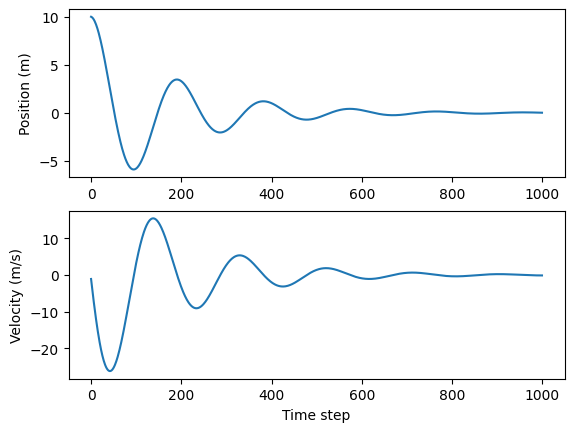

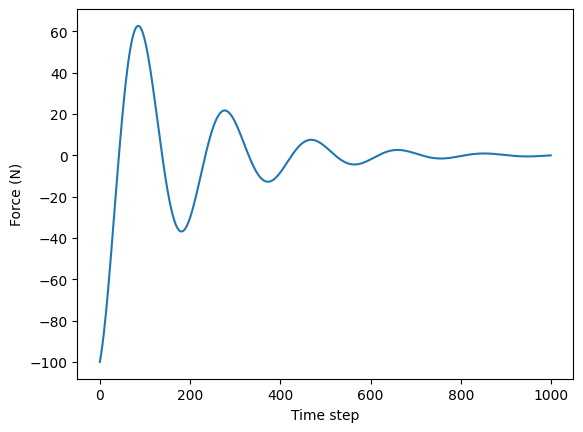

In [6]:
# Proportional controller
def proportional_control(state, target_position):
    position, velocity = state
    error = target_position - position
    force = 10.0 * error - velocity  # Proportional gain
    return force

# Simulate the mass-spring-damper system with the proportional controller
env.reset()
done = False
state_array = []
action_array = []
for _ in range(env.max_steps):
    action = [proportional_control(env.state, 0.0)]
    action_array.append(action)
    state, reward, done, _ = env.step(action)
    state_array.append(state)
    if done:
        break


# Plot the position and velocity of the mass-spring-damper system
import matplotlib.pyplot as plt
state_array = np.array(state_array)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(state_array[:, 0])
plt.ylabel('Position (m)')
plt.subplot(2, 1, 2)
plt.plot(state_array[:, 1])
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time step')
plt.show()

# plot action
action_array = np.array(action_array)
plt.figure()
plt.plot(action_array)
plt.ylabel('Force (N)')
plt.xlabel('Time step')
plt.show()



In [7]:
print(state_array)

[[ 9.989      -1.1       ]
 [ 9.9671331  -2.18669   ]
 [ 9.93454289 -3.25902105]
 ...
 [ 0.01602831 -0.13080562]
 [ 0.01471701 -0.13112987]
 [ 0.01340394 -0.13130631]]


In [8]:
import tensorflow as tf
import tensorlayer as tl
from tensorflow.keras import layers

def get_actor(num_states, upper_bound):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

# train model
x = np.array(state_array)
y = np.array(action_array)
model = get_actor(2, 100)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x, y, epochs=100, verbose=1)

# Save the model
model.save('model.h5')

# load model
model = tf.keras.models.load_model('model.h5')



Epoch 1/100
32/32 [==============================] - 1s 3ms/step - loss: 112.1461
Epoch 2/100
32/32 [==============================] - 0s 2ms/step - loss: 14.8345
Epoch 3/100
32/32 [==============================] - 0s 2ms/step - loss: 5.9717
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 2.7447
Epoch 5/100
32/32 [==============================] - 0s 2ms/step - loss: 2.4681
Epoch 6/100
32/32 [==============================] - 0s 2ms/step - loss: 7.9043
Epoch 7/100
32/32 [==============================] - 0s 2ms/step - loss: 13.0774
Epoch 8/100
32/32 [==============================] - 0s 2ms/step - loss: 3.3489
Epoch 9/100
32/32 [==============================] - 0s 2ms/step - loss: 2.3879
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 2.1101
Epoch 11/100
32/32 [==============================] - 0s 2ms/step - loss: 1.7242
Epoch 12/100
32/32 [==============================] - 0s 2ms/step - loss: 1.7680
Epoch 13/100
32/32 [=============

/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/Ali/Documents/BAI/Master/master-thesis/.env/lib/python3.11/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomUniform'>, which may lead to improper serialization.
  warnings.warn(


1/1 [==============================] - 0s 52ms/step


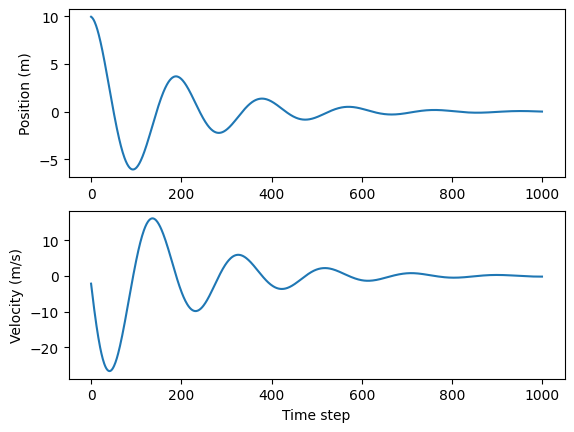

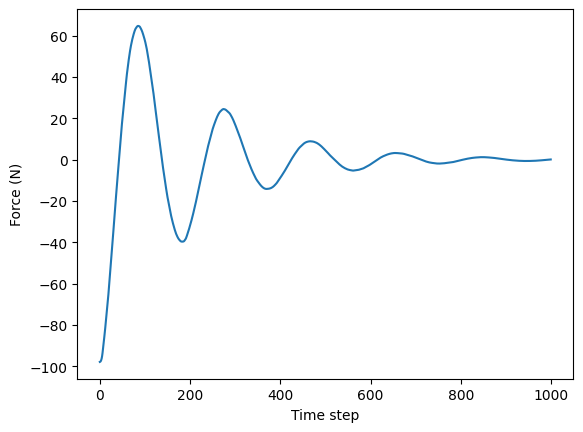

In [9]:
# Simulate the mass-spring-damper system with the trained actor
env.reset()
done = False
state_array = []
action_array = []

for _ in range(env.max_steps):
    state = np.array(env.state)
    action = model.predict(state.reshape(1, 2))
    action_array.append(action.reshape(1))
    state, reward, done, _ = env.step(action)
    state_array.append(state)
    if done:
        break


# Plot the position and velocity of the mass-spring-damper system
state_array = np.array(state_array)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(state_array[:, 0])
plt.ylabel('Position (m)')
plt.subplot(2, 1, 2)
plt.plot(state_array[:, 1])
plt.ylabel('Velocity (m/s)')
plt.xlabel('Time step')
plt.show()

# plot action
action_array = np.array(action_array)
plt.figure()
plt.plot(action_array)
plt.ylabel('Force (N)')
plt.xlabel('Time step')
plt.show()
